# CS 224D Assignment #2
# Part [1]: Deep Networks: NER Window Model

For this first part of the assignment, you'll build your first "deep" networks. On problem set 1, you computed the backpropagation gradient $\frac{\partial J}{\partial w}$ for a two-layer network; in this problem set you'll implement a slightly more complex network to perform  named entity recognition (NER).

Before beginning the programming section, you should complete parts (a) and (b) of the corresponding section of the handout.

In [1]:
import sys, os
from numpy import *
from matplotlib.pyplot import *
%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 100

%load_ext autoreload
%autoreload 2

## (c): Random Initialization Test
Use the cell below to test your code.

In [2]:
from misc import random_weight_matrix
random.seed(10)
print random_weight_matrix(3,5)

[[ 0.46994114 -0.83008197  0.23148553  0.43094097 -0.00258593]
 [-0.47666619 -0.52297046  0.45125243 -0.57311684 -0.71301636]
 [ 0.32105262  0.78530031 -0.85918681  0.02111762  0.54147539]]


## (d): Implementation

We've provided starter code to load in the dataset and convert it to a list of "windows", consisting of indices into the matrix of word vectors. 

We pad each sentence with begin and end tokens `<s>` and `</s>`, which have their own word vector representations; additionally, we convert all words to lowercase, canonicalize digits (e.g. `1.12` becomes `DG.DGDG`), and replace unknown words with a special token `UUUNKKK`.

You don't need to worry about the details of this, but you can inspect the `docs` variables or look at the raw data (in plaintext) in the `./data/` directory.

In [3]:
import data_utils.utils as du
import data_utils.ner as ner

In [4]:
# Load the starter word vectors
wv, word_to_num, num_to_word = ner.load_wv('data/ner/vocab.txt',
                                           'data/ner/wordVectors.txt')
# wv is the word-vector matrix, each row is a word vector.
# the shape of wv is (100232, 50), which means 100232 word vectors and each is 50-dimension.
tagnames = ["O", "LOC", "MISC", "ORG", "PER"]
num_to_tag = dict(enumerate(tagnames))
tag_to_num = du.invert_dict(num_to_tag)

In [5]:
# Set window size
windowsize = 3

# Load the training set
docs = du.load_dataset('data/ner/train') # There is 14042(len(docs)) sentences.

In [6]:
# each row of X is a list of word indices
# each entry of y is the word index to predict, there are 5 classes.
X_train, y_train = du.docs_to_windows(docs, word_to_num, tag_to_num,
                                      wsize=windowsize)

# Load the dev set (for tuning hyperparameters)
docs = du.load_dataset('data/ner/dev')
X_dev, y_dev = du.docs_to_windows(docs, word_to_num, tag_to_num,
                                  wsize=windowsize)

# Load the test set (dummy labels only)
docs = du.load_dataset('data/ner/test.masked')
X_test, y_test = du.docs_to_windows(docs, word_to_num, tag_to_num,
                                    wsize=windowsize)

To avoid re-inventing the wheel, we provide a base class that handles a lot of the drudgery of managing parameters and running gradient descent. It's based on the classifier API used by [`scikit-learn`](http://scikit-learn.org/stable/), so if you're familiar with that library it should be easy to use. 

We'll be using this class for the rest of this assignment, so it helps to get acquainted with a simple example that should be familiar from Assignment 1. To keep this notebook uncluttered, we've put the code in the `softmax_example.py`; take a look at it there, then run the cell below.

In [7]:
from softmax_example import SoftmaxRegression
sr = SoftmaxRegression(wv=zeros((10,100)), dims=(100,5))

##
# Automatic gradient checker!
# this checks anything you add to self.grads or self.sgrads
# using the method of Assignment 1
sr.grad_check(x=5, y=4)

grad_check: dJ/db error norm = 3.565e-10 [ok]
    b dims: [5] = 5 elem
grad_check: dJ/dW error norm = 2.164e-11 [ok]
    W dims: [5, 100] = 500 elem
grad_check: dJ/dL[5] error norm = 2.646e-11 [ok]
    L[5] dims: [100] = 100 elem


In [8]:
dims=[100, 5]
param_dims = dict(W = (dims[1], dims[0]), # 5x100 matrix
                          b = (dims[1]))

In order to implement a model, you need to subclass `NNBase`, then implement the following methods:

- `__init__()` (initialize parameters and hyperparameters)
- `_acc_grads()` (compute and accumulate gradients)
- `compute_loss()` (compute loss for a training example)
- `predict()`, `predict_proba()`, or other prediction method (for evaluation)

`NNBase` provides you with a few others that will be helpful:

- `grad_check()` (run a gradient check - calls `_acc_grads` and `compute_loss`)
- `train_sgd()` (run SGD training; more on this later)

Your task is to implement the window model in `nerwindow.py`; a scaffold has been provided for you with instructions on what to fill in.

When ready, you can test below:

In [41]:
a = empty((10,5))

In [43]:
a[0] = 0

In [44]:
a

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.02666014,  0.00481545,  0.16557235,  0.22704343,  0.04107236],
       [-0.05737776,  0.08789365, -0.07368174,  0.17448112, -0.0291805 ],
       [ 0.04109639,  0.02853432, -0.03893288,  0.11408883, -0.05731082],
       [-0.16304782, -0.04780182, -0.00839773,  0.05022159,  0.07100497],
       [-0.11315066, -0.05138587,  0.21593538,  0.18259297, -0.15887129],
       [ 0.05704504, -0.07510228, -0.04950885,  0.01140992,  0.13295227],
       [-0.1582206 , -0.07399621,  0.14180174, -0.08885161,  0.06714699],
       [-0.12901356,  0.12881674, -0.04664285,  0.13921216, -0.02563953],
       [ 0.26197244, -0.08250012,  0.02918107, -0.07576818, -0.06776849]])

In [57]:
from nerwindow import WindowMLP
clf = WindowMLP(wv, windowsize=windowsize, dims=[None, 100, 5],
                reg=0.001, alpha=0.01)
clf.grad_check(X_train[0], y_train[0]) # gradient check on single point

grad_check: dJ/db2 error norm = 3.205e-10 [ok]
    b2 dims: [5] = 5 elem
grad_check: dJ/dU error norm = 2.837e-10 [ok]
    U dims: [5, 100] = 500 elem
grad_check: dJ/db1 error norm = 2.849e-09 [ok]
    b1 dims: [100] = 100 elem
grad_check: dJ/dW error norm = 1.337e-08 [ok]
    W dims: [100, 150] = 15000 elem
grad_check: dJ/dL[30] error norm = 3.335e-11 [ok]
    L[30] dims: [50] = 50 elem
grad_check: dJ/dL[6659] error norm = 4.373e-11 [ok]
    L[6659] dims: [50] = 50 elem
grad_check: dJ/dL[12637] error norm = 4.509e-11 [ok]
    L[12637] dims: [50] = 50 elem


Now we'll train your model on some data! You can implement your own SGD method, but we recommend that you just call `clf.train_sgd`. This takes the following arguments:

- `X`, `y` : training data
- `idxiter`: iterable (list or generator) that gives index (row of X) of training examples in the order they should be visited by SGD
- `printevery`: int, prints progress after this many examples
- `costevery`: int, computes mean loss after this many examples. This is a costly operation, so don't make this too frequent!

The implementation we give you supports minibatch learning; if `idxiter` is a list-of-lists (or yields lists), then gradients will be computed for all indices in a minibatch before modifying the parameters (this is why we have you write `_acc_grad` instead of applying them directly!).

Before training, you should generate a training schedule to pass as `idxiter`. If you know how to use Python generators, we recommend those; otherwise, just make a static list. Make the following in the cell below:

- An "epoch" schedule that just iterates through the training set, in order, `nepoch` times.
- A random schedule of `N` examples sampled with replacement from the training set.
- A random schedule of `N/k` minibatches of size `k`, sampled with replacement from the training set.

In [10]:
nepoch = 5
N = nepoch * len(y_train)
k = 5 # minibatch size
random.seed(10) # do not change this!

# Epoch schedule
epoch_idxiter = nepoch * range(len(y_train))

# Random schedule of N
randomN_idxiter = random.randint(0, len(y_train), N)

# Random minibatches
randombatch_idxiter = random.randint(0, len(y_train), N).reshape(N/k, k)

Now call `train_sgd` to train on `X_train`, `y_train`. To verify that things work, train on 100,000 examples or so to start (with any of the above schedules). This shouldn't take more than a couple minutes, and you should get a mean cross-entropy loss around 0.4.

In [56]:
# To train on no more than 100,000 examples, use max_example.
clf.train_sgd(X=X_train, y=y_train, idxiter=xrange(100000), printevery=10000, costevery=20000)

Begin SGD...
  Seen 0 in 0.00 s
  [0]: mean loss 0.340659
  Seen 10000 in 7.52 s
  Seen 20000 in 9.34 s
  [20000]: mean loss 0.333674
  Seen 30000 in 16.61 s
  Seen 40000 in 18.47 s
  [40000]: mean loss 0.385317
  Seen 50000 in 25.73 s
  Seen 60000 in 27.80 s
  [60000]: mean loss 0.34217
  Seen 70000 in 35.08 s
  Seen 80000 in 36.90 s
  [80000]: mean loss 0.326269
  Seen 90000 in 44.09 s
  [100000]: mean loss 0.302032
SGD complete: 100000 examples in 51.25 seconds.


[(0, 0.34065940354382318),
 (20000, 0.33367381243879507),
 (40000, 0.38531699531836139),
 (60000, 0.34217013209875102),
 (80000, 0.32626879865019154),
 (100000, 0.30203223119396355)]

Now, if this works well, it's time for production! You have three tasks here:

1. Train a good model
2. Plot a learning curve (cost vs. # of iterations)
3. Use your best model to predict the test set

You should train on the `train` data and evaluate performance on the `dev` set. The `test` data we provided has only dummy labels (everything is `O`); we'll compare your predictions to the true labels at grading time. 

Scroll down to section (f) for the evaluation code.

We don't expect you to spend too much time doing an exhaustive search here; the default parameters should work well, although you can certainly do better. Try to achieve an F1 score of at least 76% on the dev set, as reported by `eval_performance`.

Feel free to create new cells and write new code here, including new functions (helpers and otherwise) in `nerwindow.py`. When you have a good model, follow the instructions below to make predictions on the test set.

A strong model may require 10-20 passes (or equivalent number of random samples) through the training set and could take 20 minutes or more to train - but it's also possible to be much, much faster!

Things you may want to tune:
- `alpha` (including using an "annealing" schedule to decrease the learning rate over time)
- training schedule and minibatch size
- regularization strength
- hidden layer dimension
- width of context window

In [74]:
#### YOUR CODE HERE ####
# Sandbox: build a good model by tuning hyperparameters
k = 5
randombatch_idxiter = random.randint(0, len(y_train), N).reshape(N/k, k)
models_reg = []
for reg in [ 10**i for i in range(-8,-5)]:
    clf = WindowMLP(wv, windowsize=windowsize, dims=[None, 100, 5], reg=reg, alpha=0.01)
    clf.train_sgd(X=X_train, y=y_train, idxiter=randombatch_idxiter, printevery=100000, costevery=200000)
    models_reg.append(clf)
    yp = clf.predict(X_dev)
    eval_performance(y_dev, yp, tagnames) # performance: optimize this F1
    print "############# Models with reg_term = {} done. ##############".format(reg)
#### END YOUR CODE ####

Begin SGD...
  Seen 0 in 0.00 s
  [0]: mean loss 1.77988
  Seen 100000 in 120.57 s
  Seen 200000 in 241.60 s
  [200000]: mean loss 0.0783189
  [203621]: mean loss 0.0825818
SGD complete: 203621 examples in 260.41 seconds.
=== Performance (omitting 'O' class) ===
Mean precision:  83.49%
Mean recall:     77.74%
Mean F1:         80.49%
############# Models with reg_term = 1e-08 done. ##############
Begin SGD...
  Seen 0 in 0.00 s
  [0]: mean loss 1.77988
  Seen 100000 in 129.45 s
  Seen 200000 in 249.29 s
  [200000]: mean loss 0.0783263
  [203621]: mean loss 0.0825884
SGD complete: 203621 examples in 268.03 seconds.
=== Performance (omitting 'O' class) ===
Mean precision:  83.48%
Mean recall:     77.73%
Mean F1:         80.48%
############# Models with reg_term = 1e-07 done. ##############
Begin SGD...
  Seen 0 in 0.00 s
  [0]: mean loss 1.77988
  Seen 100000 in 119.33 s
  Seen 200000 in 233.02 s
  [200000]: mean loss 0.0784161
  [203621]: mean loss 0.0825699
SGD complete: 203621 examples

In [76]:
#### YOUR CODE HERE ####
# Sandbox: build a good model by tuning hyperparameters
for alpha in [10**i for i in range(-4,1)]:
    clf = WindowMLP(wv, windowsize=windowsize, dims=[None, 100, 5], reg=10**(-8), alpha=alpha)
    clf.train_sgd(X=X_train, y=y_train, idxiter=randombatch_idxiter, printevery=100000, costevery=200000)
    yp = clf.predict(X_dev)
    eval_performance(y_dev, yp, tagnames) # performance: optimize this F1
    print "############# Models with alpha = {} done. ##############".format(alpha)

#### END YOUR CODE ####
# alpha = 0.01 best

Begin SGD...
  Seen 0 in 0.00 s
  [0]: mean loss 1.77988
  Seen 100000 in 102.69 s
  Seen 200000 in 183.84 s
  [200000]: mean loss 0.332983
  [203621]: mean loss 0.332392
SGD complete: 203621 examples in 200.50 seconds.
=== Performance (omitting 'O' class) ===
Mean precision:  66.99%
Mean recall:     44.03%
Mean F1:         52.40%
############# Models with alpha = 0.0001 done. ##############
Begin SGD...
  Seen 0 in 0.00 s
  [0]: mean loss 1.77988
  Seen 100000 in 107.04 s
  Seen 200000 in 204.00 s
  [200000]: mean loss 0.221631
  [203621]: mean loss 0.218734
SGD complete: 203621 examples in 222.52 seconds.
=== Performance (omitting 'O' class) ===
Mean precision:  75.39%
Mean recall:     63.42%
Mean F1:         68.32%
############# Models with alpha = 0.001 done. ##############
Begin SGD...
  Seen 0 in 0.00 s
  [0]: mean loss 1.77988
  Seen 100000 in 92.93 s
  Seen 200000 in 180.07 s
  [200000]: mean loss 0.0783189
  [203621]: mean loss 0.0825818
SGD complete: 203621 examples in 196.01

## (e): Plot Learning Curves
The `train_sgd` function returns a list of points `(counter, cost)` giving the mean loss after that number of SGD iterations.

If the model is taking too long you can cut it off by going to *Kernel->Interrupt* in the IPython menu; `train_sgd` will return the training curve so-far, and you can restart without losing your training progress.

Make two plots:

- Learning curve using `reg = 0.001`, and comparing the effect of changing the learning rate: run with `alpha = 0.01` and `alpha = 0.1`. Use minibatches of size 5, and train for 10,000 minibatches with `costevery=200`. Be sure to scale up your counts (x-axis) to reflect the batch size. What happens if the model tries to learn too fast? Explain why this occurs, based on the relation of SGD to the true objective.

- Learning curve for your best model (print the hyperparameters in the title), as trained using your best schedule. Set `costevery` so that you get at least 100 points to plot.

In [99]:
##
# Plot your best learning curve here
windowsize = 3
k = 5
randombatch_idxiter = random.randint(0, len(y_train), 50000).reshape(50000/k, k)

clf1 = WindowMLP(wv, windowsize=windowsize, dims=[None, 100, 5], reg=10**(-3), alpha=0.01)
clf1.train_sgd(X=X_train, y=y_train, idxiter=randombatch_idxiter, printevery=200, costevery=200)

clf2 = WindowMLP(wv, windowsize=windowsize, dims=[None, 100, 5], reg=10**(-3), alpha=0.1)
clf2.train_sgd(X=X_train, y=y_train, idxiter=randombatch_idxiter, printevery=200, costevery=200)

Begin SGD...
  Seen 0 in 0.00 s
SGD Interrupted: saw 0 examples in 1.88 seconds.
Begin SGD...
  Seen 0 in 0.00 s
SGD Interrupted: saw 0 examples in 1.18 seconds.


[]

In [102]:
randombatch_idxiter = random.randint(0, len(y_train), 50000).reshape(50000/k, k)

clf = WindowMLP(wv, windowsize=3, dims=[None, 100, 5], reg=0.00001, alpha=0.01)
traincurvebest = clf.train_sgd(X=X_train, y=y_train, idxiter=randombatch_idxiter, printevery=50000, costevery=200)

Begin SGD...
  Seen 0 in 0.00 s
  [0]: mean loss 1.77988
  [200]: mean loss 0.45885
  [400]: mean loss 0.433913
  [600]: mean loss 0.415147
  [800]: mean loss 0.41583
  [1000]: mean loss 0.39384
  [1200]: mean loss 0.386884
  [1400]: mean loss 0.387832
  [1600]: mean loss 0.379977
  [1800]: mean loss 0.383588
  [2000]: mean loss 0.375746
  [2200]: mean loss 0.366106
  [2400]: mean loss 0.377221
  [2600]: mean loss 0.362769
  [2800]: mean loss 0.358312
  [3000]: mean loss 0.354717
  [3200]: mean loss 0.357433
  [3400]: mean loss 0.353685
  [3600]: mean loss 0.35128
  [3800]: mean loss 0.347542
  [4000]: mean loss 0.347684
  [4200]: mean loss 0.346154
  [4400]: mean loss 0.356961
  [4600]: mean loss 0.343673
  [4800]: mean loss 0.35846
  [5000]: mean loss 0.342433
  [5200]: mean loss 0.340072
  [5400]: mean loss 0.335411
  [5600]: mean loss 0.334756
  [5800]: mean loss 0.329734
  [6000]: mean loss 0.335292
  [6200]: mean loss 0.325392
  [6400]: mean loss 0.323655
  [6600]: mean loss 0.32

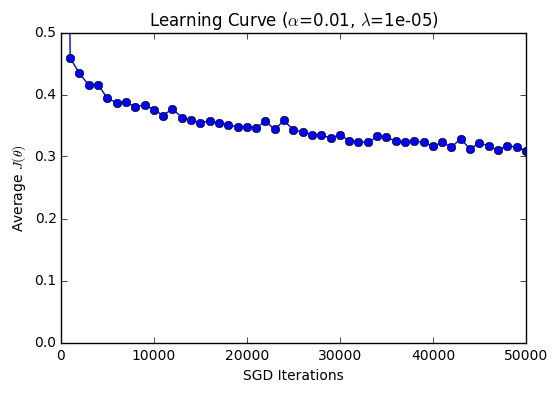

In [103]:
counts, costs = zip(*traincurvebest)
figure(figsize=(6,4))
plot(5*array(counts), costs, color='b', marker='o', linestyle='-')
title(r"Learning Curve ($\alpha$=%g, $\lambda$=%g)" % (clf.alpha, clf.lreg))
xlabel("SGD Iterations"); ylabel(r"Average $J(\theta)$"); 
ylim(ymin=0, ymax=max(1.1*max(costs),3*min(costs)));
ylim(0,0.5)

# Don't change this filename!
savefig("ner.learningcurve.best.png")

In [12]:
##
# Plot comparison of learning rates here
# feel free to change the code below

figure(figsize=(6,4))
counts, costs = zip(*trainingcurve1)
plot(5*array(counts), costs, color='b', marker='o', linestyle='-', label=r"$\alpha=0.01$")
counts, costs = zip(*trainingcurve2)
plot(5*array(counts), costs, color='g', marker='o', linestyle='-', label=r"$\alpha=0.1$")
title(r"Learning Curve ($\lambda=0.01$, minibatch k=5)")
xlabel("SGD Iterations"); ylabel(r"Average $J(\theta)$"); 
ylim(ymin=0, ymax=max(1.1*max(costs),3*min(costs)));
legend()

# Don't change this filename
savefig("ner.learningcurve.comparison.png")

## (f): Evaluating your model
Evaluate the model on the dev set using your `predict` function, and compute performance metrics below!

In [70]:
# Predict labels on the dev set
yp = models_reg[2].predict(X_dev)
# Save predictions to a file, one per line
ner.save_predictions(yp, "dev.predicted")

In [71]:
from nerwindow import full_report, eval_performance
full_report(y_dev, yp, tagnames) # full report, helpful diagnostics
eval_performance(y_dev, yp, tagnames) # performance: optimize this F1

             precision    recall  f1-score   support

          O       0.92      0.98      0.95     42759
        LOC       0.77      0.46      0.58      2094
       MISC       0.66      0.33      0.44      1268
        ORG       0.38      0.26      0.31      2092
        PER       0.72      0.56      0.63      3149

avg / total       0.87      0.89      0.87     51362

=== Performance (omitting 'O' class) ===
Mean precision:  63.98%
Mean recall:     42.89%
Mean F1:         51.07%


In [15]:
# Save your predictions on the test set for us to evaluate
# IMPORTANT: make sure X_test is exactly as loaded 
# from du.docs_to_windows, so that your predictions 
# line up with ours.
yptest = clf.predict(X_test)
ner.save_predictions(yptest, "test.predicted")

## Part [1.1]: Probing neuron responses

You might have seen some results from computer vision where the individual neurons learn to detect edges, shapes, or even [cat faces](http://googleblog.blogspot.com/2012/06/using-large-scale-brain-simulations-for.html). We're going to do the same for language.

Recall that each "neuron" is essentially a logistic regression unit, with weights corresponding to rows of the corresponding matrix. So, if we have a hidden layer of dimension 100, then we can think of our matrix $W \in \mathbb{R}^{100 x 150}$ as representing 100 hidden neurons each with weights `W[i,:]` and bias `b1[i]`.

### (a): Hidden Layer, Center Word
For now, let's just look at the center word, and ignore the rest of the window. This corresponds to columns `W[:,50:100]`, although this could change if you altered the window size for your model. For each neuron, find the top 10 words that it responds to, as measured by the dot product between `W[i,50:100]` and `L[j]`. Use the provided code to print these words and their scores for 5 neurons of your choice. In your writeup, briefly describe what you notice here.

The `num_to_word` dictionary, loaded earlier, may be helpful.

In [114]:
# Recommended function to print scores
# scores = list of float
# words = list of str
def print_scores(scores, words):
    for i in range(len(scores)):
        print "[%d]: (%.03f) %s" % (i, scores[i], words[i])

#### YOUR CODE HERE ####

neurons = [5, 16, 9] # change this to your chosen neurons
for i in neurons:
    print "Neuron %d" % i
    scores = clf.params.W[i, 50:100].dot(clf.sparams.L.T) + clf.params.b1[i]
    topwords_idx = sorted(range(len(scores)), key=lambda i:scores[i], reverse=True)[:10]
    topwords = [num_to_word[key] for key in topwords_idx]
    topscores = [scores[key] for key in topwords_idx]

    print_scores(topscores, topwords)
    
#### END YOUR CODE ####

Neuron 5
[0]: (1.406) most
[1]: (1.315) folk
[2]: (1.288) lyrics
[3]: (1.243) ethnic
[4]: (1.220) hundreds
[5]: (1.206) settlements
[6]: (1.185) interesting
[7]: (1.184) dialect
[8]: (1.171) scattered
[9]: (1.160) sounds
Neuron 16
[0]: (1.394) represented
[1]: (1.246) unite
[2]: (1.237) whose
[3]: (1.217) no
[4]: (1.213) replace
[5]: (1.209) distribute
[6]: (1.197) spoken
[7]: (1.194) refrain
[8]: (1.178) collective
[9]: (1.168) label
Neuron 9
[0]: (1.337) morning
[1]: (1.247) loaves
[2]: (1.231) afternoon
[3]: (1.199) wept
[4]: (1.196) bowl
[5]: (1.190) hurry
[6]: (1.164) bake
[7]: (1.156) biscuit
[8]: (1.145) smiled
[9]: (1.138) dough


### (b): Model Output, Center Word
Now, let's do the same for the output layer. Here we only have 5 neurons, one for each class. `O` isn't very interesting, but let's look at the other four.

Here things get a little more complicated: since we take a softmax, we can't just look at the neurons separately. An input could cause several of these neurons to all have a strong response, so we really need to compute the softmax output and find the strongest inputs for each class.

As before, let's consider only the center word (`W[:,50:100]`). For each class `ORG`, `PER`, `LOC`, and `MISC`, find the input words that give the highest probability $P(\text{class}\ |\ \text{word})$.

You'll need to do the full feed-forward computation here - for efficiency, try to express this as a matrix operation on $L$. This is the same feed-forward computation as used to predict probabilities, just with $W$ replaced by `W[:,50:100]`.

As with the hidden-layer neurons, print the top 10 words and their corresponding class probabilities for each class.

In [126]:
from nn.math import softmax
#### YOUR CODE HERE ####

P = empty((clf.sparams.L.shape[0], clf.nclass))

for i, row in enumerate(clf.sparams.L):

    h = tanh(clf.params.W[:, 50:100].dot(row) + clf.params.b1)
    p = softmax(clf.params.U.dot(h) + clf.params.b2)
    P[i, :] = p

In [129]:
softmax_trans = P.T

In [130]:
topwords = [[] for i in range(softmax_trans.shape[0])]
topscores = [[] for i in range(softmax_trans.shape[0])]

In [133]:
for i, row in enumerate(softmax_trans):
    topwords_idx = sorted(range(len(row)), key=lambda i:row[i], reverse=True)[:10]
    topwords[i] = [num_to_word[idx] for idx in topwords_idx]
    topscores[i] = [row[idx] for idx in topwords_idx]

for i in range(1,5):
    print "Output neuron %d: %s" % (i, num_to_tag[i])
    print_scores(topscores[i], topwords[i])
    print ""

#### END YOUR CODE ####

Output neuron 1: LOC
[0]: (0.983) china
[1]: (0.976) japan
[2]: (0.976) indonesia
[3]: (0.975) korea
[4]: (0.972) italy
[5]: (0.968) thailand
[6]: (0.967) taiwan
[7]: (0.965) france
[8]: (0.965) russia
[9]: (0.962) germany

Output neuron 2: MISC
[0]: (0.938) danish
[1]: (0.937) turkish
[2]: (0.922) 18th
[3]: (0.921) iranian
[4]: (0.921) greek
[5]: (0.917) italian
[6]: (0.917) ottoman
[7]: (0.916) ancient
[8]: (0.911) egyptian
[9]: (0.911) swedish

Output neuron 3: ORG
[0]: (0.890) department
[1]: (0.889) commons
[2]: (0.882) arts
[3]: (0.870) campus
[4]: (0.868) corps
[5]: (0.840) theatre
[6]: (0.839) college
[7]: (0.838) steam
[8]: (0.836) union
[9]: (0.835) engineering

Output neuron 4: PER
[0]: (0.997) thompson
[1]: (0.996) martin
[2]: (0.995) dale
[3]: (0.995) trembling
[4]: (0.995) matthew
[5]: (0.995) sarah
[6]: (0.994) daniel
[7]: (0.993) matt
[8]: (0.993) pat
[9]: (0.993) wept



### (c): Model Output, Preceding Word
Now for one final task: let's look at the preceding word. Repeat the above analysis for the output layer, but use the first part of $W$, i.e. `W[:,:50]`.

Describe what you see, and include these results in your writeup.

In [135]:
#### YOUR CODE HERE ####
P_prec = empty((clf.sparams.L.shape[0], clf.nclass))

for i, row in enumerate(clf.sparams.L):

    h = tanh(clf.params.W[:, :50].dot(row) + clf.params.b1)
    p = softmax(clf.params.U.dot(h) + clf.params.b2)
    P_prec[i, :] = p

softmax_prec_trans = P_prec.T
topwords_prec = [[] for i in range(softmax_prec_trans.shape[0])]
topscores_prec = [[] for i in range(softmax_prec_trans.shape[0])]

for i, row in enumerate(softmax_prec_trans):
    topwords_prec_idx = sorted(range(len(row)), key=lambda i:row[i], reverse=True)[:10]
    topwords_prec[i] = [num_to_word[idx] for idx in topwords_prec_idx]
    topscores_prec[i] = [row[idx] for idx in topwords_prec_idx]

for i in range(1,5):
    print "Output neuron %d: %s" % (i, num_to_tag[i])
    print_scores(topscores_prec[i], topwords_prec[i])
    print ""

#### END YOUR CODE ####

Output neuron 1: LOC
[0]: (0.821) southwest
[1]: (0.714) surrounded
[2]: (0.672) situated
[3]: (0.665) southeast
[4]: (0.629) located
[5]: (0.603) governed
[6]: (0.587) central
[7]: (0.573) northeast
[8]: (0.547) namely
[9]: (0.528) inner

Output neuron 2: MISC
[0]: (0.356) </s>
[1]: (0.329) advent
[2]: (0.320) world
[3]: (0.319) notable
[4]: (0.309) instance
[5]: (0.307) seasons
[6]: (0.298) addition
[7]: (0.290) putting
[8]: (0.285) stages
[9]: (0.285) comprises

Output neuron 3: ORG
[0]: (0.749) christ
[1]: (0.745) memorial
[2]: (0.708) athens
[3]: (0.702) cross
[4]: (0.693) jerusalem
[5]: (0.685) open
[6]: (0.681) st
[7]: (0.642) avenue
[8]: (0.631) ad
[9]: (0.623) rugby

Output neuron 4: PER
[0]: (0.983) assistant
[1]: (0.980) mate
[2]: (0.978) egotistical
[3]: (0.977) manager
[4]: (0.976) naturalist
[5]: (0.976) pianist
[6]: (0.974) acumen
[7]: (0.973) owl
[8]: (0.973) adviser
[9]: (0.970) aunt

